In [1]:
import numpy as np
import pandas as pd
import pickle
import os

### Plotting settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import to_rgb

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('image', cmap='viridis')

plt.rcParams.update({
    "font.family": "serif",  
    # use serif/main font for text elements
    })
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'axes.linewidth': 2.5})
plt.rcParams.update({'axes.labelweight': 'bold'})
plt.rcParams.update({'axes.labelsize': 20})
plt.rc('legend',fontsize=12)


#### Function for subject
def sep_conditions(files_list):
    group_beh = pd.concat(files_list, axis = 0)
    
    conditions_dict = {"fix_rand": {},
                  "fix_det": {},
                 "att_rand": {},
                 "att_det": {}}

    conditions_dict["att_rand"]["df"] = group_beh[(group_beh['block_type'] == 'random') &
                        (group_beh['block_task'] == 'Pay attention to the images!')].reset_index()
    conditions_dict["att_det"]["df"] = group_beh[(group_beh['block_type'] == 'determ') &
                        (group_beh['block_task'] == 'Pay attention to the images!')].reset_index()
    conditions_dict["fix_rand"]["df"] = group_beh[(group_beh['block_type'] == 'random') &
                        (group_beh['block_task'] == 'Pay attention to the fixation cross!')].reset_index()
    conditions_dict["fix_det"]["df"] = group_beh[(group_beh['block_type'] == 'determ') &
                        (group_beh['block_task'] == 'Pay attention to the fixation cross!')].reset_index()
    return conditions_dict
    
def compute_metrics(conditions_dict):
    metrics = {}
    for key in conditions_dict.keys():
        metrics[key] = {}
        df = conditions_dict[key]["df"]
        response_trials = df[df['key_resp_3.keys'].notna()]

        # Calculate Mean RT for correct responses
        metrics[key]["rt"] = response_trials[response_trials['key_resp_3.corr'] == 1]['key_resp_3.rt'].mean()

        # Total non-catch trials and hit trials
        non_catch_trials = df[df['catch_trial'] == True]
        hit_trials = non_catch_trials[non_catch_trials['key_resp_3.corr'] == 1]
        metrics[key]["hit"] = len(hit_trials) / len(non_catch_trials) if len(non_catch_trials) > 0 else 0

        # Total catch trials and false alarms
        catch_trials = df[df['catch_trial'] == False]
        false_alarm_trials = catch_trials[catch_trials['key_resp_3.keys'].notna()]
        metrics[key]["fa"] = len(false_alarm_trials) / len(catch_trials) if len(catch_trials) > 0 else 0
        
    return metrics

def dump_data(data, filename):
    # Ensure the directory exists
    directory = os.path.dirname(filename)
    
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist. Creating it.")
        os.makedirs(directory)

    print('writing file: ' + filename)
    with open(filename, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

def load_data(file):
   
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data) 

conds  = ["fix", "img"]
files = []
subjects = [13]
for sub in subjects:
    sub_files = []
    
    for cond in conds:
        files.append(pd.read_csv(f'/projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh/sub{sub:02d}/{sub}_eeg_exp_{cond}.csv'))
        sub_files.append(pd.read_csv(f'/projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh/sub{sub:02d}/{sub}_eeg_exp_{cond}.csv'))
    
    sub_dict = sep_conditions(sub_files)
    sub_metrics = compute_metrics(sub_dict)
    metric_file_name = f'/projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_{sub:02d}'
    dump_data(sub_metrics, metric_file_name)

writing file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_13


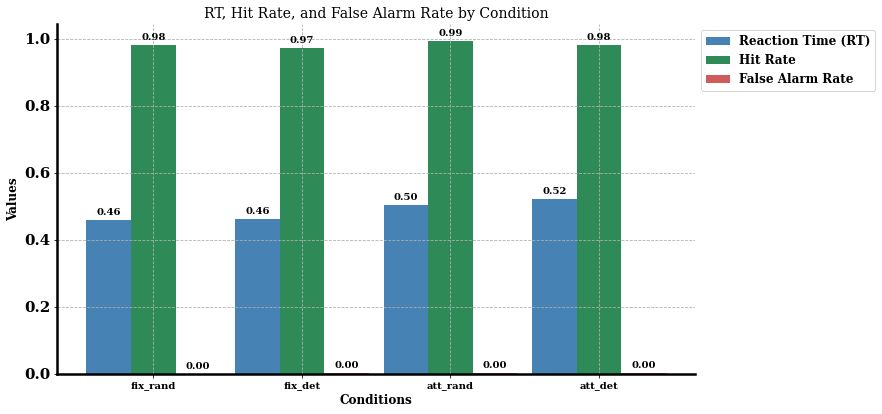

In [94]:
# Prepare data for plotting
condition_labels = list(conditions.keys())
rts = [conditions[key]["rt"] for key in condition_labels]
hit_rates = [conditions[key]["hit"] for key in condition_labels]
false_alarm_rates = [conditions[key]["fa"] for key in condition_labels]

# Set up bar width and positions
x = np.arange(len(condition_labels))  # Position of bars on x-axis
width = 0.3  # Width of bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bar1 = ax.bar(x - width, rts, width, label='Reaction Time (RT)', color='steelblue')
bar2 = ax.bar(x, hit_rates, width, label='Hit Rate', color='seagreen')
bar3 = ax.bar(x + width, false_alarm_rates, width, label='False Alarm Rate', color='indianred')

# Add labels, title, and legend
ax.set_xlabel('Conditions', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('RT, Hit Rate, and False Alarm Rate by Condition', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(condition_labels, fontsize=10)
ax.legend()

# Add value annotations to bars
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.grid(True, linestyle='--')
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()


In [99]:
### Compute the behavioural relevant effect
att_exp_effect = []
for sub in subjects:
    sub_metric = load_data(f'/projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_{sub:02d}')
    att_exp_effect.append(sub_metric["att_det"]["rt"] - sub_metric["att_rand"]["rt"])
    

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_00
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_01
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_02
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_03
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_04
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_05
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_07
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_08
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_10
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_11
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/beh_metrics/metrics_12

In [100]:
np.array(att_exp_effect) * 100

array([ 0.4173975 , -1.39932824, -0.44813001,  3.55708194,  4.40675396,
       -1.82183417,  2.81210111,  1.24799945,  3.30233083, -0.37589498,
        3.43867694])